## Assignment: Convolution using Toeplitz Matrix

---


In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la

### Reading the image

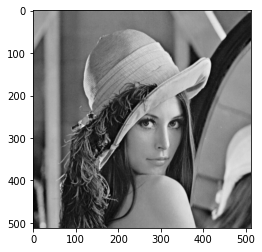

In [81]:
img = cv2.imread('../images/lena.png', 0)
plt.imshow(img, cmap='gray')
plt.show()

### Resizing the image

Resizing the image to make it smaller as it is too large for the GPU to handle.

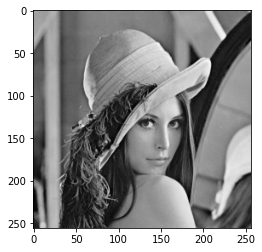

(256, 256)


In [82]:
resized_img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
plt.imshow(resized_img, cmap='gray')
plt.show()

print(resized_img.shape)

### Defining the kernel(Filter) and padding

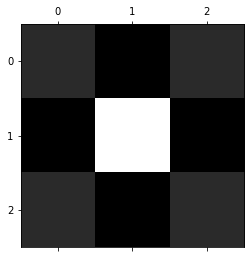

In [107]:
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.int8)
kernel_size = kernel.shape[0]
padding = (kernel_size - 1) // 2

plt.matshow(kernel, cmap='gray')
plt.show()

### Paddding the image with boundary values

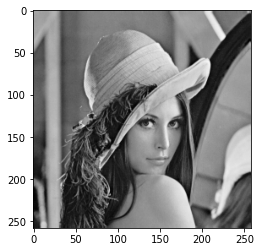

In [84]:
padded_img = cv2.copyMakeBorder(resized_img, padding, padding, padding, padding, cv2.BORDER_REPLICATE)
plt.imshow(padded_img, cmap='gray')
plt.show()

### Image & Kernel Shape

In [85]:
image_row, image_col = padded_img.shape[:2]
kernel_row, kernel_col = kernel.shape[:2]

### Calculating output dimensions

In [86]:
output_row = image_row + kernel_row - 1
output_col = image_col + kernel_col - 1
output_shape = (output_row, output_col)
print(output_shape)

(260, 260)


### Zero padding the kernel to make it same size as the image

In [87]:
zero_padded_filter = np.pad(kernel, ((output_row - kernel_row, 0), (0, output_col - kernel_col)), 'constant', constant_values=0)
print(zero_padded_filter)
print(zero_padded_filter.shape)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0 -1  0 ...  0  0  0]
 [-1  5 -1 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]]
(260, 260)


### Toeplitz Matrix

In [88]:
toeplitz_list = []

for i in range(zero_padded_filter.shape[0] -1, -1, -1):
    c = zero_padded_filter[i, :]
    r = np.r_[c[0], np.zeros(image_col - 1, dtype=np.int8)]
    toeplitz_list.append(la.toeplitz(c, r))

print(toeplitz_list)
print(len(toeplitz_list))

[array([[ 0,  0,  0, ...,  0,  0,  0],
       [-1,  0,  0, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0, -1,  0],
       [ 0,  0,  0, ...,  0,  0, -1],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8), array([[-1,  0,  0, ...,  0,  0,  0],
       [ 5, -1,  0, ...,  0,  0,  0],
       [-1,  5, -1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., -1,  5, -1],
       [ 0,  0,  0, ...,  0, -1,  5],
       [ 0,  0,  0, ...,  0,  0, -1]], dtype=int8), array([[ 0,  0,  0, ...,  0,  0,  0],
       [-1,  0,  0, ...,  0,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0, -1,  0],
       [ 0,  0,  0, ...,  0,  0, -1],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8), array([[0, 0, 0, ..

### Doubly Toeplitz Matrix

In [89]:
c = range(1, zero_padded_filter.shape[0] + 1)
r = np.r_[c[0], np.zeros(image_col - 1, dtype=np.int8)]
doubly_toeplitz = la.toeplitz(c, r)

print(doubly_toeplitz)
print(doubly_toeplitz.shape)
print(doubly_toeplitz.size)

[[  1   0   0 ...   0   0   0]
 [  2   1   0 ...   0   0   0]
 [  3   2   1 ...   0   0   0]
 ...
 [258 257 256 ...   3   2   1]
 [259 258 257 ...   4   3   2]
 [260 259 258 ...   5   4   3]]
(260, 258)
67080


### Doubly Block Toeplitz Matrix

In [91]:
h = toeplitz_list[0].shape[0] * doubly_toeplitz.shape[0]
w = toeplitz_list[0].shape[1] * doubly_toeplitz.shape[1]

doubly_blocked_toeplitz = np.zeros((h, w), dtype=np.int8)

print(doubly_blocked_toeplitz)
print(doubly_blocked_toeplitz.shape)
print(doubly_blocked_toeplitz.size)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(67600, 66564)
4499726400


### Filling the doublly block toeplitz matrix

In [92]:
for i in range(toeplitz_list[0].shape[0]):
    for j in range(toeplitz_list[0].shape[1]):
        r_start = i * toeplitz_list[0].shape[0]
        r_end = r_start + toeplitz_list[0].shape[0]
        c_start = j * toeplitz_list[0].shape[1]
        c_end = c_start + toeplitz_list[0].shape[1]
        doubly_blocked_toeplitz[r_start:r_end, c_start:c_end] = toeplitz_list[doubly_toeplitz[i, j] - 1]

print(doubly_blocked_toeplitz)
print(doubly_blocked_toeplitz.shape)

[[ 0  0  0 ...  0  0  0]
 [-1  0  0 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0 -1  0]
 [ 0  0  0 ...  0  0 -1]
 [ 0  0  0 ...  0  0  0]]
(67600, 66564)


### Converting the image to a matrix

In [93]:
def matrix_to_vector(matrix):
    height, width = matrix.shape[:2]
    vector = np.zeros(height * width, dtype=np.int8)

    matrix = np.flipud(matrix)
    for i, row in enumerate(matrix):
        vector[i * width : i * width + width] = row
    
    return vector

In [94]:
vectorized_image = matrix_to_vector(padded_img)

print(vectorized_image)
print(vectorized_image.shape)
print(vectorized_image.size)

[  53   53   63 ...  -79 -106 -106]
(66564,)
66564


### Performing convolution as a matrix multiplication

In [95]:
result = np.matmul(doubly_blocked_toeplitz, vectorized_image)
print("Result: ", result)

Result:  [  0 -53 -53 ... 106 106   0]


### Converting back the vector to an image

In [96]:
def vector_to_matrix(vector, shape):
    height, width = shape[:2]
    matrix = np.zeros(shape, dtype=np.int8)

    for i in range(height):
        matrix[i, :] = vector[i * width : i * width + width]
    
    return np.flipud(matrix)

### Showing the result and comparing with the result of `filter2D`

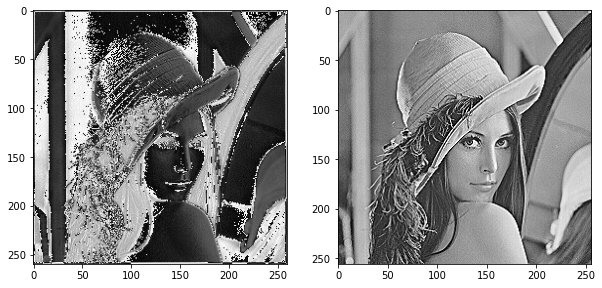

In [97]:
output_image = vector_to_matrix(result, output_shape)
convolved_image = cv2.filter2D(resized_img, -1, kernel, borderType=cv2.BORDER_REPLICATE)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(output_image, cmap='gray')
axes[1].imshow(convolved_image, cmap='gray')
plt.show()

### Histogram equalization

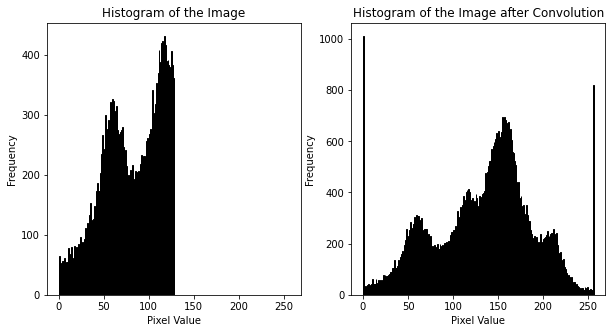

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(output_image.ravel(), bins=256, range=(0, 256), fc='k', ec='k')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of the Image')
axes[1].hist(convolved_image.ravel(), bins=256, range=(0, 256), fc='k', ec='k')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of the Image after Convolution')
plt.show()